## E6 Project Stock Prediction
 - 학습 목표
    - 시계열 데이터의 특성과 안정적(Stationary) 시계열의 개념을 이해한다.
    - ARIMA 모델을 구성하는 AR, MA, Diffencing의 개념을 이해하고 간단한 시계열 데이터에 적용해 본다.
    - 실제 주식 데이터에 ARIMA를 적용해서 예측 정확도를 확인해 본다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

#### (1) 시계열 데이터 준비

In [2]:
AMD_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/AMD.csv'
AAPL_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/AAPL.csv'
NVDA_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/NVDA.csv'

amd_df = pd.read_csv(AMD_filepath, index_col='Date', parse_dates=True)
aapl_df = pd.read_csv(AAPL_filepath, index_col='Date', parse_dates=True)
nvda_df = pd.read_csv(NVDA_filepath, index_col='Date', parse_dates=True)
aapl_df 

amd_ts = amd_df['Close']
aapl_ts = aapl_df['Close']
nvda_ts = nvda_df['Close']

#### (2) 전처리
- 결측치처리


In [3]:
amd_ts=amd_ts.interpolate(method='time')
aapl_ts=aapl_ts.interpolate(method='time')
nvda_ts=nvda_ts.interpolate(method='time')

- 로그 변환
    - 시계열 데이터의 분산을 일정하게 만들어 줍니다 

In [4]:
amd_ts_log = np.log(amd_ts)
aapl_ts_log = np.log(aapl_ts)
nvda_ts_log = np.log(nvda_ts)

#### (3) 시계열 안정성 분석

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    plt.figure(figsize=(12,8))
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

- AMD 

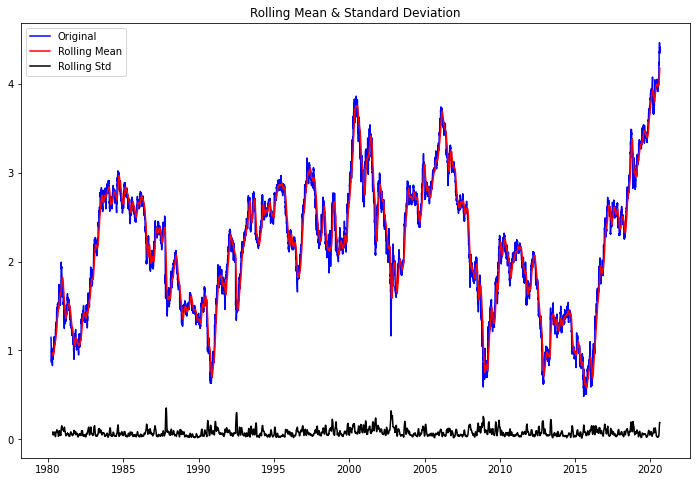

Results of Dickey-Fuller Test:
Test Statistic                    -2.103255
p-value                            0.243208
#Lags Used                         7.000000
Number of Observations Used    10182.000000
Critical Value (1%)               -3.430992
Critical Value (5%)               -2.861824
Critical Value (10%)              -2.566921
dtype: float64


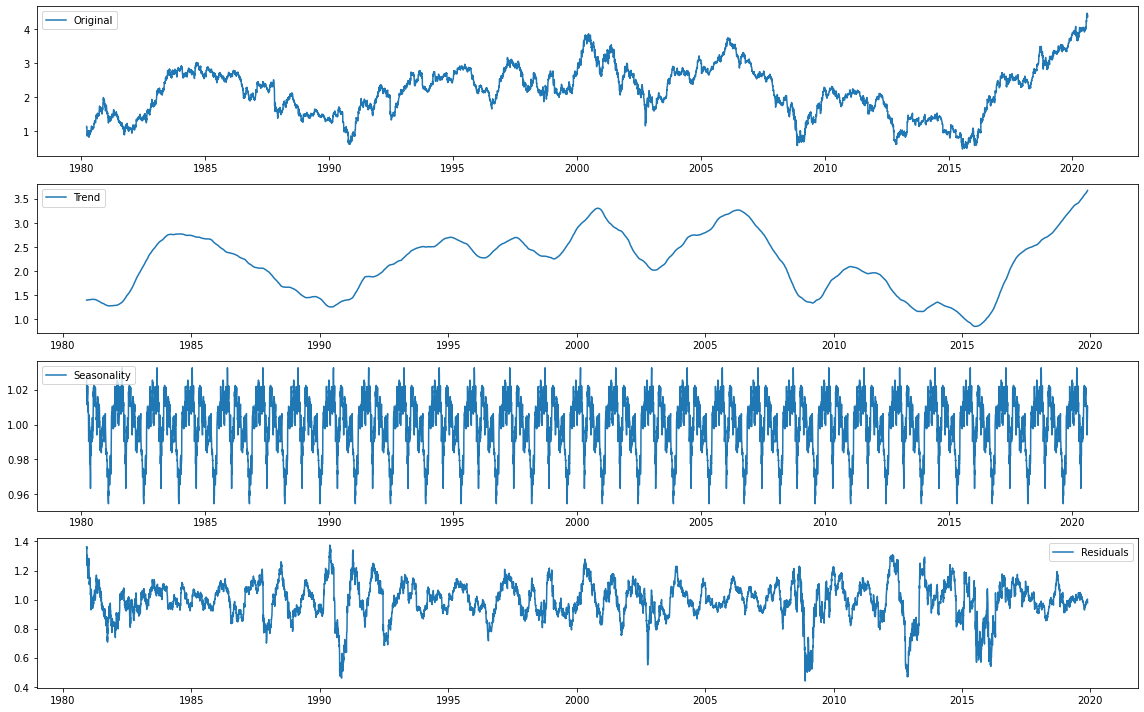

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(amd_ts_log, window=30)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(amd_ts_log)

# 시계열 분해(Time Series Decomposition)
decomposition = seasonal_decompose(amd_ts_log, model='multiplicative', period = 360)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 10))
plt.subplot(411)
plt.plot(amd_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.401173e+00
p-value                        6.181807e-16
#Lags Used                     3.000000e+01
Number of Observations Used    9.799000e+03
Critical Value (1%)           -3.431018e+00
Critical Value (5%)           -2.861835e+00
Critical Value (10%)          -2.566927e+00
dtype: float64


- AAPL

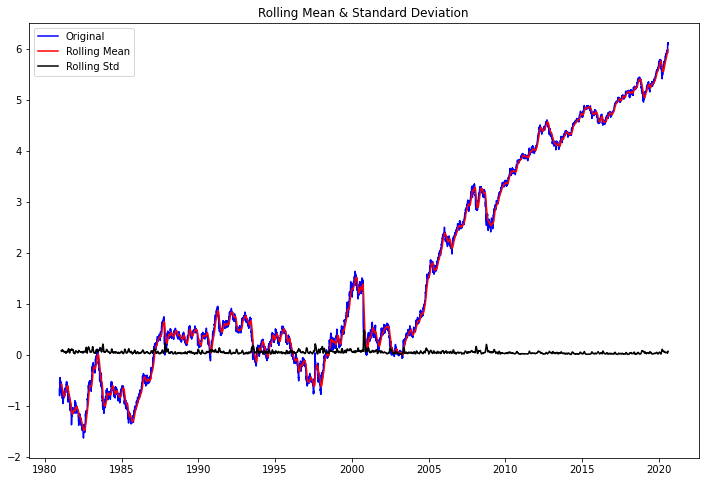

Results of Dickey-Fuller Test:
Test Statistic                    0.516547
p-value                           0.985367
#Lags Used                       14.000000
Number of Observations Used    9987.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


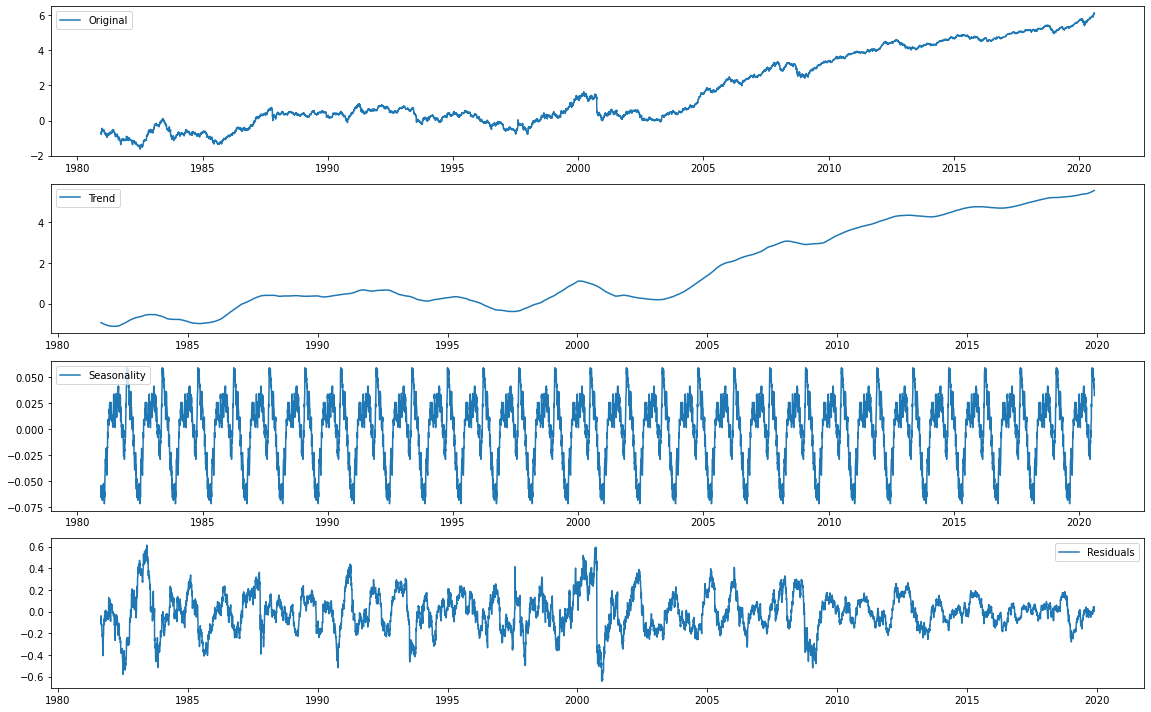

In [12]:
# 정성적 그래프 분석
plot_rolling_statistics(aapl_ts_log, window=30)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(aapl_ts_log)

# 시계열 분해(Time Series Decomposition)
decomposition = seasonal_decompose(aapl_ts_log, model='additive', period = 360)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 10))
plt.subplot(411)
plt.plot(aapl_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [13]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.028027e+00
p-value                        5.541651e-15
#Lags Used                     1.700000e+01
Number of Observations Used    9.624000e+03
Critical Value (1%)           -3.431030e+00
Critical Value (5%)           -2.861840e+00
Critical Value (10%)          -2.566930e+00
dtype: float64


-NVDA

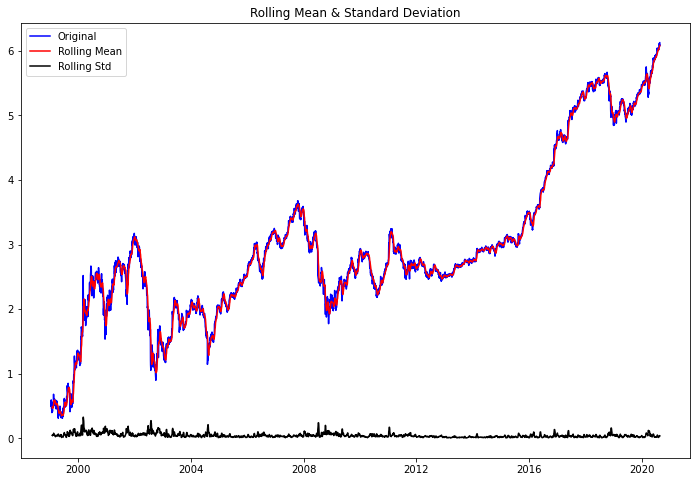

Results of Dickey-Fuller Test:
Test Statistic                   -0.590006
p-value                           0.873224
#Lags Used                       24.000000
Number of Observations Used    5400.000000
Critical Value (1%)              -3.431562
Critical Value (5%)              -2.862075
Critical Value (10%)             -2.567055
dtype: float64


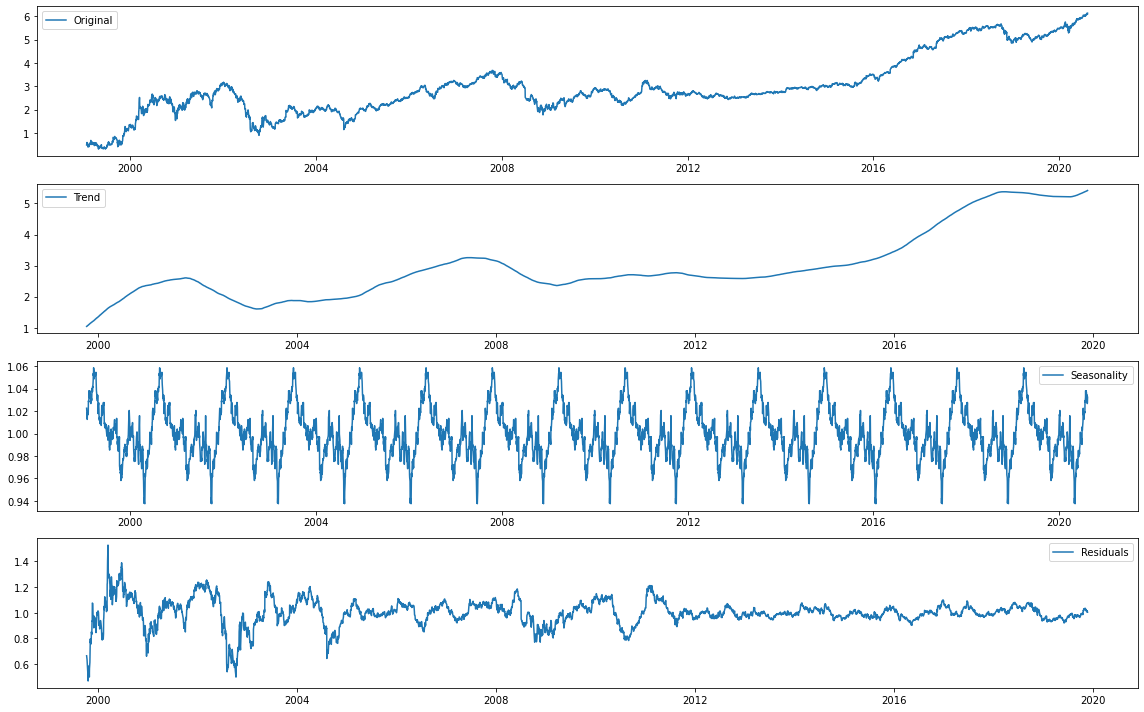

In [14]:
# 정성적 그래프 분석
plot_rolling_statistics(nvda_ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(nvda_ts_log)

# 시계열 분해(Time Series Decomposition)
decomposition = seasonal_decompose(nvda_ts_log, model='multiplicative', period = 360)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 10))
plt.subplot(411)
plt.plot(nvda_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [15]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.083520e+00
p-value                        1.077973e-07
#Lags Used                     3.000000e+01
Number of Observations Used    5.034000e+03
Critical Value (1%)           -3.431650e+00
Critical Value (5%)           -2.862114e+00
Critical Value (10%)          -2.567076e+00
dtype: float64


#### (4) 학습, 테스트 데이터셋 생성
- AMD

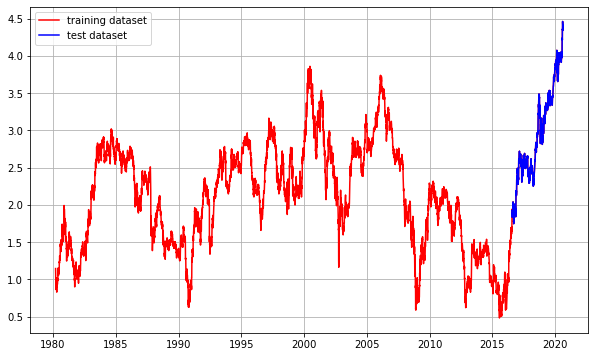

In [16]:
amd_train_data, amd_test_data = amd_ts_log[:int(len(amd_ts_log)*0.9)], amd_ts_log[int(len(amd_ts_log)*0.9):]
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(amd_ts_log, c='r', label='training dataset')
plt.plot(amd_test_data, c='b', label='test dataset')
plt.legend()

- AAPL

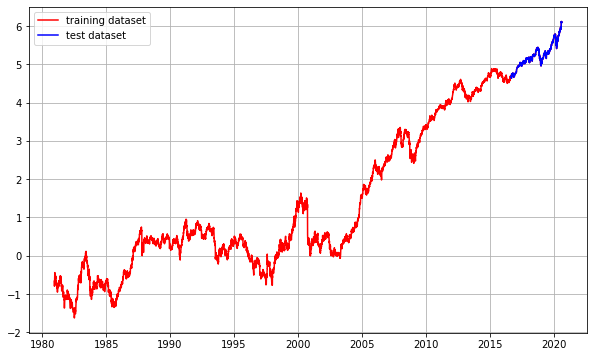

In [17]:
aapl_train_data, aapl_test_data = aapl_ts_log[:int(len(aapl_ts_log)*0.9)], aapl_ts_log[int(len(aapl_ts_log)*0.9):]
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(aapl_ts_log, c='r', label='training dataset')
plt.plot(aapl_test_data, c='b', label='test dataset')
plt.legend()

- NVDA

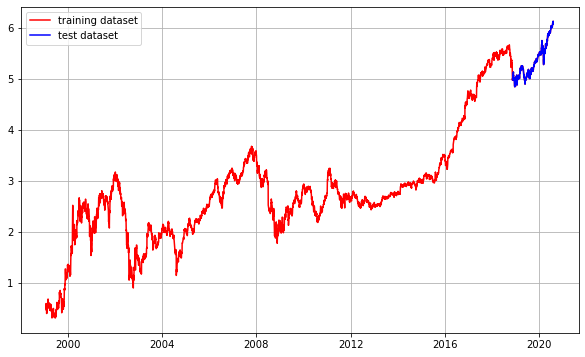

In [18]:
nvda_train_data, nvda_test_data = nvda_ts_log[:int(len(nvda_ts_log)*0.92)], nvda_ts_log[int(len(nvda_ts_log)*0.92):]
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(nvda_ts_log, c='r', label='training dataset')
plt.plot(nvda_test_data, c='b', label='test dataset')
plt.legend()

#### (5) 적정ARIMA 모수 찾기 
- AMD

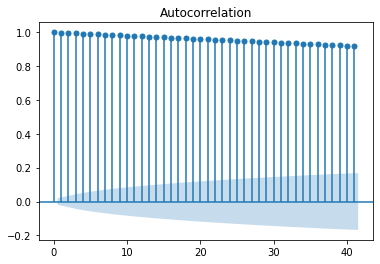

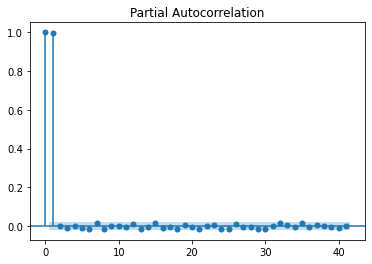

In [19]:
plot_acf(amd_ts_log)
plot_pacf(amd_ts_log)
plt.show()

- AAPL

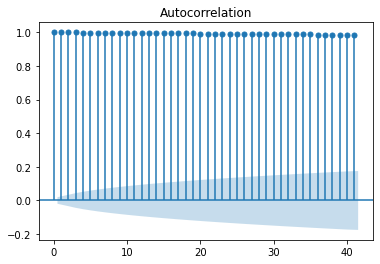

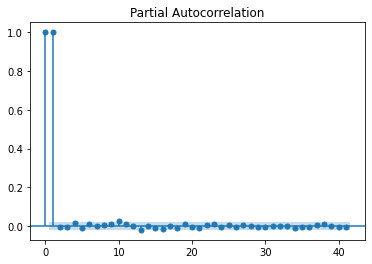

In [20]:
plot_acf(aapl_ts_log)
plot_pacf(aapl_ts_log)
plt.show()

- NVDA

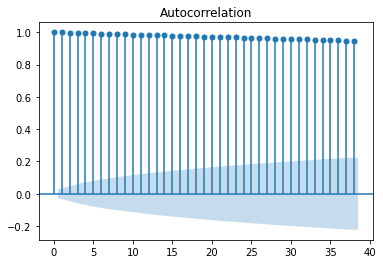

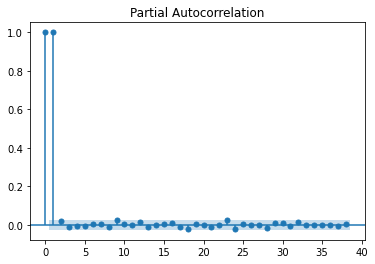

In [21]:
plot_acf(nvda_ts_log)
plot_pacf(nvda_ts_log)
plt.show()

-AMD

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


Results of Dickey-Fuller Test:
Test Statistic                   -37.509873
p-value                            0.000000
#Lags Used                         6.000000
Number of Observations Used    10182.000000
Critical Value (1%)               -3.430992
Critical Value (5%)               -2.861824
Critical Value (10%)              -2.566921
dtype: float64


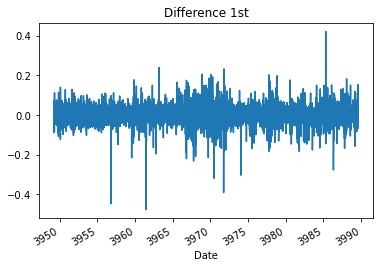

In [22]:
amd_diff_1 = amd_ts_log.diff(periods=1).iloc[1:]
amd_diff_1.plot(title='Difference 1st')


augmented_dickey_fuller_test(amd_diff_1)


- AAPL

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


Results of Dickey-Fuller Test:
Test Statistic                  -25.433341
p-value                           0.000000
#Lags Used                       13.000000
Number of Observations Used    9987.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


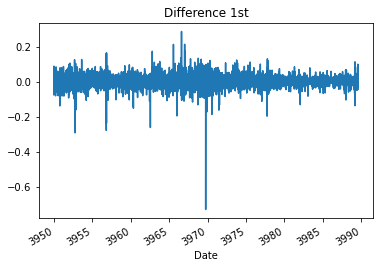

In [23]:
aapl_diff_1 = aapl_ts_log.diff(periods=1).iloc[1:]
aapl_diff_1.plot(title='Difference 1st')


augmented_dickey_fuller_test(aapl_diff_1)


- NVDA

Results of Dickey-Fuller Test:
Test Statistic                -1.430654e+01
p-value                        1.204133e-26
#Lags Used                     2.300000e+01
Number of Observations Used    5.400000e+03
Critical Value (1%)           -3.431562e+00
Critical Value (5%)           -2.862075e+00
Critical Value (10%)          -2.567055e+00
dtype: float64


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


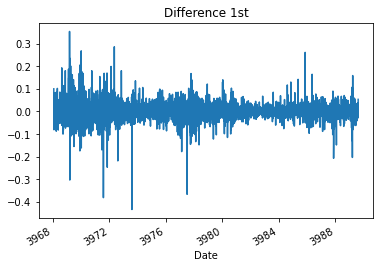

In [24]:
nvda_diff_1 = nvda_ts_log.diff(periods=1).iloc[1:]
nvda_diff_1.plot(title='Difference 1st')


augmented_dickey_fuller_test(nvda_diff_1)


#### (6) ARIMA 모델 훈련과 테스트

-AMD   

In [25]:
model = ARIMA(amd_train_data, order=(0, 0, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 9171
Model:                     ARMA(0, 1)   Log Likelihood               -3618.346
Method:                       css-mle   S.D. of innovations              0.359
Date:                Fri, 14 Aug 2020   AIC                           7242.691
Time:                        11:50:57   BIC                           7264.063
Sample:                             0   HQIC                          7249.956
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1006      0.007    285.151      0.000       2.086       2.115
ma.L1.Close     0.9654      0.002    485.572      0.000       0.961       0.969
                                    Roots       

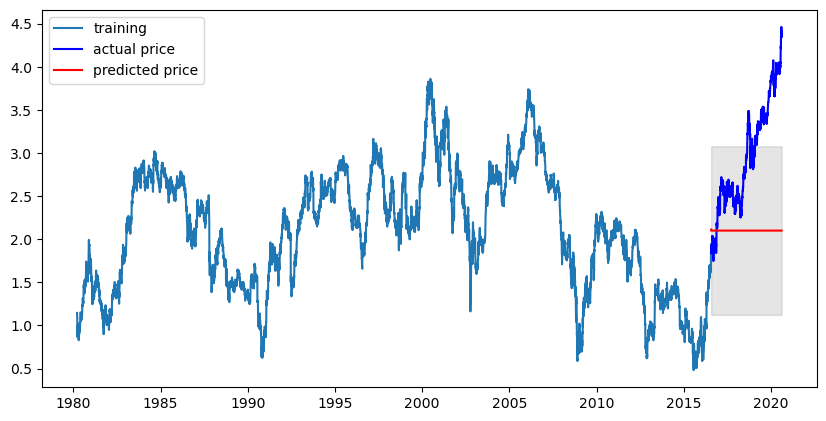

In [26]:
fc, se, conf = fitted_m.forecast(len(amd_test_data), alpha=0.05)

fc_series = pd.Series(fc, index=amd_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=amd_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=amd_test_data.index)  # 예측결과의 상한 바운드

plt.figure(figsize=(10,5), dpi=100)
plt.plot(amd_train_data, label='training')
plt.plot(amd_test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [27]:
mse = mean_squared_error(np.exp(amd_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(amd_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(amd_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(amd_test_data))/np.abs(np.exp(amd_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  487.77192066604977
MAE:  15.734333565425953
RMSE:  22.085559097882257
MAPE: 52.43%


- p:1 d:1 q:0
    - MAPE : 55.96%
- p:0 d:0 q:1
    - MAPE : 52.43%
    
- 전체적인 그래프의 형태를 보았을 때 기존의 추세와는 다른 추세를 보여주어 오히려 AR은 예측에 도움이 되지 않을 것 같아 0으로 바꾸고 최근의 증감을 반영하기 위해 MA는 1 그리고 I는 0으로 설정하였더니 미세하게 성능의 향상이 보였습니다. 

- AAPL   

In [28]:
model = ARIMA(aapl_train_data, order=(1, 2, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 8999
Model:                 ARIMA(1, 2, 1)   Log Likelihood               18764.774
Method:                       css-mle   S.D. of innovations              0.030
Date:                Fri, 14 Aug 2020   AIC                         -37521.548
Time:                        11:51:02   BIC                         -37493.129
Sample:                             2   HQIC                        -37511.878
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.145e-07   1.28e-07      0.898      0.369   -1.35e-07    3.64e-07
ar.L1.D2.Close     0.0242      0.011      2.299      0.021       0.004       0.045
ma.L1.D2.Close    -0.9999      0.000

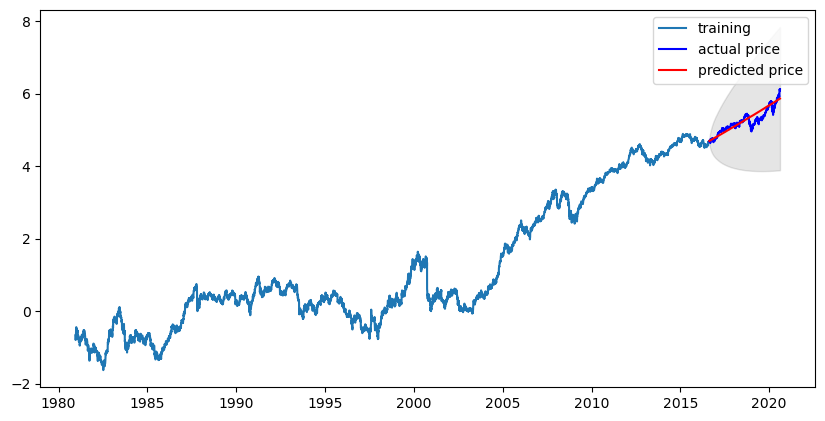

In [29]:
fc, se, conf = fitted_m.forecast(len(aapl_test_data), alpha=0.05)

fc_series = pd.Series(fc, index=aapl_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=aapl_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=aapl_test_data.index)  # 예측결과의 상한 바운드

plt.figure(figsize=(10,5), dpi=100)
plt.plot(aapl_train_data, label='training')
plt.plot(aapl_test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [30]:
mse = mean_squared_error(np.exp(aapl_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(aapl_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(aapl_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(aapl_test_data))/np.abs(np.exp(aapl_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  918.8087125715779
MAE:  22.55928627894473
RMSE:  30.311857623240083
MAPE: 11.27%


- p:1 d:1 q:0
    - MAPE : 20.83%
- p:1 d:2 q:1
    - MAPE : 11.27%   
    
- 전체적으로 비슷한 형태의 그래프이나 최근에 들어 이전보다 더욱 빠르게 상승하는 모습을 보여 MA를 1로 변경하였습니다. 또한 I를 2차로 변경하니 성능이 조금더 향상되는 모습을 보였습니다.

- NVDA   

In [31]:
model = ARIMA(nvda_train_data, order=(1, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4990
Model:                 ARIMA(1, 1, 1)   Log Likelihood                9104.506
Method:                       css-mle   S.D. of innovations              0.039
Date:                Fri, 14 Aug 2020   AIC                         -18201.011
Time:                        11:51:04   BIC                         -18174.950
Sample:                             1   HQIC                        -18191.876
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      1.603      0.109      -0.000       0.002
ar.L1.D.Close    -0.3877      0.311     -1.245      0.213      -0.998       0.223
ma.L1.D.Close     0.4075      0.308     

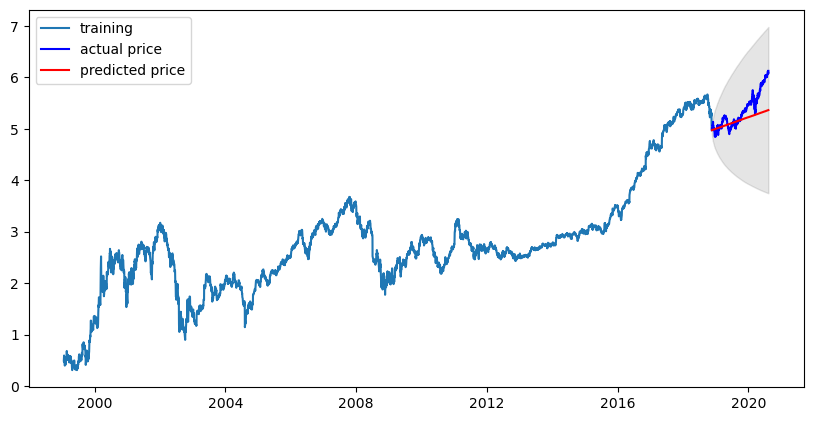

In [32]:
fc, se, conf = fitted_m.forecast(len(nvda_test_data), alpha=0.05)

fc_series = pd.Series(fc, index=nvda_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=nvda_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=nvda_test_data.index)  # 예측결과의 상한 바운드

plt.figure(figsize=(10,5), dpi=100)
plt.plot(nvda_train_data, label='training')
plt.plot(nvda_test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [33]:
mse = mean_squared_error(np.exp(nvda_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(nvda_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(nvda_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(nvda_test_data))/np.abs(np.exp(nvda_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  6225.633234659898
MAE:  50.29380117914583
RMSE:  78.90268204985112
MAPE: 17.36%


- Train data 비율 : 0.9 
    - p : 1, d : 1, q : 0  
    - MAPE : 68.28%   
    - p : 1, d : 0, q : 1
    - MAPE : 30.64%
- Train Data 비율 : 0.92
    - p : 1, d : 1, q : 1
    - MAPE : 17.36%
    
- 데이터의 비율을 0.9로 하였을때는 MA를 1로 설정하여 최근의 패턴을 반영하였더니 성능의 향상이 있었습니다. 
- 데이터를 나누는 비율을 변경하여 그래프가 반대 방향으로 급격하게 변하는 부분을 생략하여 주니 오히려 성능이 더욱 크게 향상되었습니다. 

#### (7) 고찰

- 시계열 분석이 전통적인 통계 방식에서 많이 연구되고 통계 모델이 만들어져 있지만 미래를 예측해야하는 일이기에 한계가 있었습니다. 
- 다양한 요소가 반영되는 주가를 차트만으로 분석하는 것은 정확성에서 많은 문제를 보였습니다. 
- 이론에 따라 p,q,d 파라미터를 변경하여 보았을 때 큰 성능의 향상에는 어려움이 있었고 오히려 데이터 자체가 일정한 주기를 잘 보여주는 경우에는 좋은 성능을 보여주었습니다. 
- 따라서 차트를 이용한 주가 예측에는 한계가 있고 전체 기간이 아닌 일정한 패턴을 보이는 구간을 잘라서 여러개의 예측 모델을 만드는 등 다양한 방법의 시도가 있어야 할것이라고 생각합니다.